# Predicting Energy Consumption and Production Using Transformer Models

## Description
In this notebook, we will develop a machine learning model to predict whether the energy consumption of a household will be lower than its energy production in the next hour. We will use a Transformer model with the Time2Vector embedding to capture temporal information. The process includes data loading, preprocessing, normalization, PCA for dimensionality reduction, model training, and evaluation. Let's dive into the process step-by-step.

### Imports

We start by importing all necessary libraries and modules required for our analysis and model building.

In [1]:
import sys
sys.path.append('..')

In [2]:
import os
import tensorflow as tf # type: ignore
import numpy as np # type: ignore
import time # type: ignore
import logging
import matplotlib.pyplot as plt # type: ignore
import matplotlib.dates as mdates
import pandas as pd
import seaborn as sns # type: ignore
import coloredlogs # type: ignore
from utils.transformers import Time2Vector, TransformerBlock
from utils.model_utils  import load_data, preprocess_data, select_features, normalize_data, apply_pca, remove_nans, create_tf_dataset, build_model, split_data

### Global Variables
We define some global constants that will be used throughout the notebook, such as sequence length, batch size, learning rate, and other model parameters.

In [3]:
# Global variables
SEQ_LENGTH = 60
TRAIN_END_DATE = '2023-12-31'
HEAD_SIZE = 256
NUM_HEADS = 4
FF_DIM = 4
NUM_TRANSFORMER_BLOCKS = 4
MLP_UNITS = [128]
DROPOUT = 0.1
MLP_DROPOUT = 0.1
LEARNING_RATE = 1e-4
BATCH_SIZE = 32
EPOCHS = 1
EARLY_STOPPING_PATIENCE = 5

DATA_DIR = '../data'
MODELS_DIR = '../models'
PROCESSED_DATA_DIR = 'processed_data'

os.makedirs(DATA_DIR, exist_ok=True)
os.makedirs(MODELS_DIR, exist_ok=True)
os.makedirs(PROCESSED_DATA_DIR, exist_ok=True)

### Logging Configuration
We configure the logging to track the progress and debug information during the execution of the notebook.

In [4]:
# Logging configuration
logger = logging.getLogger(__name__)
coloredlogs.install(level='DEBUG', logger=logger, fmt='%(asctime)s %(levelname)s %(message)s')

# Ignore TF warnings
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
tf.get_logger().setLevel('ERROR')


### TensorFlow and Device Configuration
We configure TensorFlow to use GPUs if available for faster computations.

In [5]:
# Forcing GPU usage
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        logger.info(f"{len(gpus)} physical GPUs, {len(logical_gpus)} logical GPUs")
    except RuntimeError as e:
        logger.error(e)

2024-08-02 15:53:01 INFO 1 physical GPUs, 1 logical GPUs


### Load Data
We load the household energy consumption data from a CSV file.

In [6]:
# Load data
data = load_data(os.path.join(DATA_DIR, 'household_data_1min_singleindex.csv'))

2024-08-02 15:53:01 INFO Loading data
/Users/charly/Sites/autonolas/PEAQ/notebooks/../utils/model_utils.py:112: DtypeWarning: Columns (70) have mixed types. Specify dtype option on import or set low_memory=False.
  return pd.read_csv(file_path, parse_dates=['cet_cest_timestamp'], index_col='cet_cest_timestamp')


### Exploratory Analysis

We perform an analysis of the variables, the balance of classes, and feature correlations to understand our data better.

In [7]:
# Analysis of variables
# columns1 = [
#         'DE_KN_residential2_circulation_pump', 
#         'DE_KN_residential2_dishwasher', 
#         'DE_KN_residential2_freezer', 
#         'DE_KN_residential2_grid_import',
#         'DE_KN_residential2_washing_machine',
#         'DE_KN_residential1_pv']

columns1 = [
        'DE_KN_residential1_dishwasher',
        'DE_KN_residential1_freezer',
        'DE_KN_residential1_grid_import',
        'DE_KN_residential1_heat_pump',
        'DE_KN_residential1_pv',
        'DE_KN_residential1_washing_machine'
]

columns2 = [
        'DE_KN_residential2_circulation_pump',
        'DE_KN_residential2_dishwasher',
        'DE_KN_residential2_freezer',
        'DE_KN_residential2_grid_import',
        'DE_KN_residential2_washing_machine'
]

columns3 = [
        'DE_KN_residential3_circulation_pump',
        'DE_KN_residential3_dishwasher',
        'DE_KN_residential3_freezer',
        'DE_KN_residential3_grid_export',
        'DE_KN_residential3_grid_import',
        'DE_KN_residential3_pv',
        'DE_KN_residential3_refrigerator',
        'DE_KN_residential3_washing_machine',
]

columns4 = [
        'DE_KN_residential4_dishwasher',
        'DE_KN_residential4_ev',
        'DE_KN_residential4_freezer',
        'DE_KN_residential4_grid_export',
        'DE_KN_residential4_grid_import',
        'DE_KN_residential4_heat_pump',
        'DE_KN_residential4_pv',
        'DE_KN_residential4_refrigerator',
        'DE_KN_residential4_washing_machine',
]

columns5 = [
        'DE_KN_residential5_dishwasher',
        'DE_KN_residential5_grid_import',
        'DE_KN_residential5_refrigerator',
        'DE_KN_residential5_washing_machine',
]

columns6 = [
        'DE_KN_residential6_circulation_pump',
        'DE_KN_residential6_dishwasher',
        'DE_KN_residential6_freezer',
        'DE_KN_residential6_grid_export',
        'DE_KN_residential6_grid_import',
        'DE_KN_residential6_pv',
        'DE_KN_residential6_washing_machine',
]

/Users/charly/miniforge3/lib/python3.10/site-packages/IPython/core/events.py:82: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/Users/charly/miniforge3/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


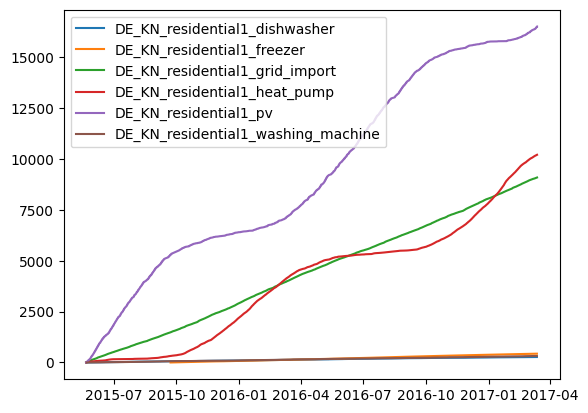

In [34]:
lineObjects = plt.plot(data[columns1])
plt.legend(iter(lineObjects), tuple(columns1))
plt.show()

/Users/charly/miniforge3/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


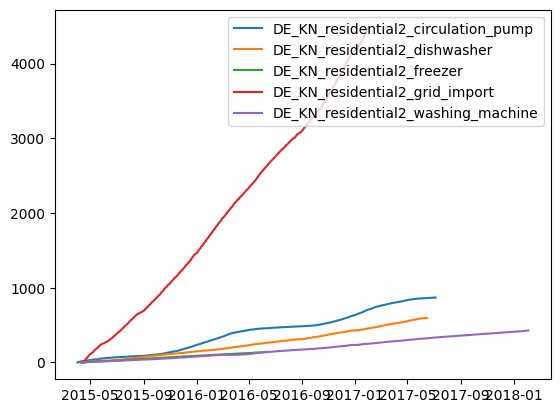

In [36]:
lineObjects = plt.plot(data[columns2])
plt.legend(iter(lineObjects), tuple(columns2))
plt.show()

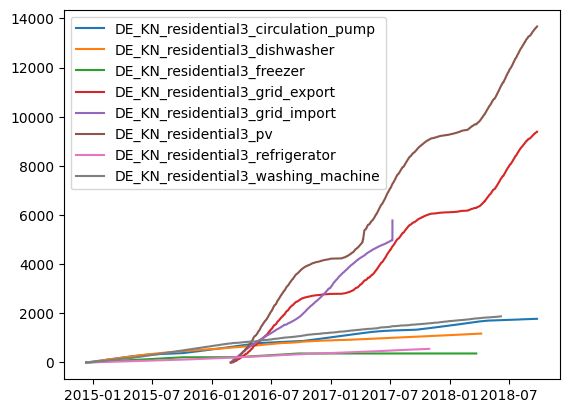

In [37]:
lineObjects = plt.plot(data[columns3])
plt.legend(iter(lineObjects), tuple(columns3))
plt.show()  

/Users/charly/miniforge3/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


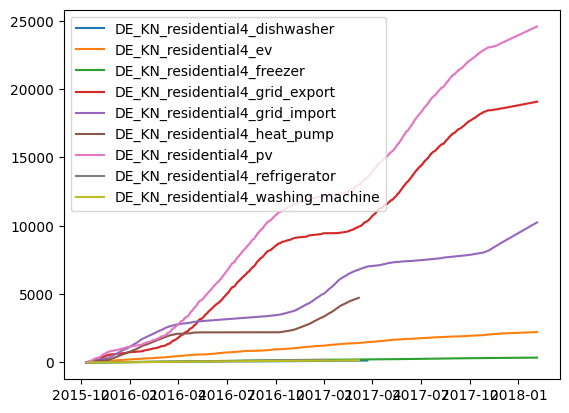

In [38]:
lineObjects = plt.plot(data[columns4])
plt.legend(iter(lineObjects), tuple(columns4))
plt.show()

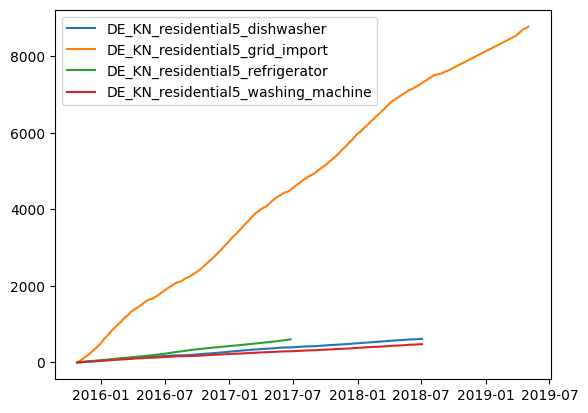

In [39]:
lineObjects = plt.plot(data[columns5])
plt.legend(iter(lineObjects), tuple(columns5))
plt.show()

/Users/charly/miniforge3/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


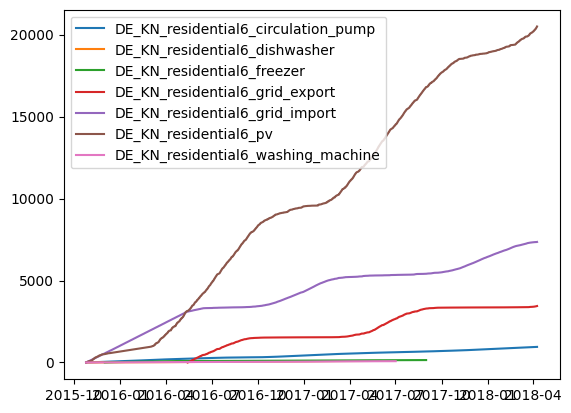

In [40]:
lineObjects = plt.plot(data[columns6])
plt.legend(iter(lineObjects), tuple(columns6))
plt.show()

In [19]:
data[columns1].describe()

,DE_KN_residential1_dishwasher,DE_KN_residential1_freezer,DE_KN_residential1_grid_import,DE_KN_residential1_heat_pump,DE_KN_residential1_pv,DE_KN_residential1_washing_machine
count,950657.000000,773695.000000,952288.000000,952288.000000,952288.000000,950701.000000
mean,143.866069,215.598335,4446.889478,4026.932342,9332.800023,155.648048
std,79.375569,127.329373,2650.273398,2934.064472,4800.037701,92.470786
min,0.000000,0.001000,0.003000,0.000000,0.010000,0.000000
25%,73.622000,103.736000,2043.815500,809.229000,5885.751000,78.218000
50%,146.753000,210.376000,4509.530500,4754.210000,8210.398000,156.274000
75%,217.838000,330.340000,6689.060750,5668.969250,14641.912000,232.831000
max,268.599000,432.761000,9096.383000,10213.523000,16521.859000,320.321000


In [20]:
data[columns2].describe()

,DE_KN_residential2_circulation_pump,DE_KN_residential2_dishwasher,DE_KN_residential2_freezer,DE_KN_residential2_grid_import,DE_KN_residential2_washing_machine
count,1.189350e+06,1.147948e+06,614987.000000,947824.000000,1.483921e+06
mean,4.084777e+02,2.576643e+02,70.821490,2017.327662,1.926070e+02
std,2.671057e+02,1.725169e+02,40.777707,1276.610681,1.298028e+02
min,1.000000e-03,0.000000e+00,0.000000,0.000000,0.000000e+00
25%,1.301650e+02,1.094560e+02,34.940000,843.116500,7.680800e+01
50%,4.479960e+02,2.435490e+02,72.536000,1988.889000,1.740980e+02
75%,5.959658e+02,4.012770e+02,106.244000,3055.729250,3.129110e+02
max,8.688850e+02,5.963510e+02,140.505000,4495.448000,4.280200e+02


In [21]:
data[columns3].describe()

,DE_KN_residential3_circulation_pump,DE_KN_residential3_dishwasher,DE_KN_residential3_freezer,DE_KN_residential3_grid_export,DE_KN_residential3_grid_import,DE_KN_residential3_pv,DE_KN_residential3_refrigerator,DE_KN_residential3_washing_machine
count,1.992576e+06,1.745742e+06,1.723855e+06,1.353257e+06,714159.000000,1.353256e+06,1.505981e+06,1.832706e+06
mean,9.501481e+02,7.131943e+02,2.681584e+02,4.379180e+03,2508.730502,6.617964e+03,2.592242e+02,9.989745e+02
std,5.263461e+02,3.252883e+02,1.127242e+02,2.498119e+03,1516.856240,3.714973e+03,1.661289e+02,5.530942e+02
min,0.000000e+00,0.000000e+00,2.000000e-03,0.000000e+00,0.007000,0.000000e+00,0.000000e+00,0.000000e+00
25%,4.623528e+02,4.694310e+02,2.126695e+02,2.668843e+03,1196.114000,3.941027e+03,1.056820e+02,5.324520e+02
50%,9.198955e+02,7.962020e+02,3.221780e+02,4.190434e+03,2325.950000,6.592381e+03,2.506040e+02,1.042498e+03
75%,1.372459e+03,9.863240e+02,3.662680e+02,6.159709e+03,3981.188000,9.405719e+03,4.051740e+02,1.485650e+03
max,1.777363e+03,1.175990e+03,3.662680e+02,9.388804e+03,5778.129000,1.367366e+04,5.533620e+02,1.878474e+03


In [22]:
data[columns4].describe()

,DE_KN_residential4_dishwasher,DE_KN_residential4_ev,DE_KN_residential4_freezer,DE_KN_residential4_grid_export,DE_KN_residential4_grid_import,DE_KN_residential4_heat_pump,DE_KN_residential4_pv,DE_KN_residential4_refrigerator,DE_KN_residential4_washing_machine
count,757134.000000,1.217206e+06,1.217201e+06,1.221516e+06,1.221510e+06,738565.000000,1.221513e+06,645780.000000,735406.000000
mean,71.154494,1.165316e+03,1.835990e+02,9.141415e+03,5.008457e+03,2090.455346,1.174413e+04,92.366358,77.840050
std,38.156823,6.682241e+02,1.034942e+02,6.223121e+03,2.777221e+03,1112.673118,7.755379e+03,58.290111,47.377631
min,0.000000,2.200000e-02,0.000000e+00,0.000000e+00,2.000000e-03,0.002000,0.000000e+00,0.000000,0.000000
25%,39.661000,5.852380e+02,9.029100e+01,3.115830e+03,3.001861e+03,1543.192000,4.452825e+03,41.712000,35.285000
50%,75.526000,1.163792e+03,1.918120e+02,9.308469e+03,4.449540e+03,2203.601000,1.197368e+04,83.532500,81.528000
75%,98.327000,1.788282e+03,2.696280e+02,1.470284e+04,7.504916e+03,2344.011000,1.864335e+04,147.580000,118.499000
max,141.800000,2.225187e+03,3.542930e+02,1.907075e+04,1.024709e+04,4728.830000,2.457644e+04,193.862000,158.355000


In [23]:
data[columns5].describe()

,DE_KN_residential5_dishwasher,DE_KN_residential5_grid_import,DE_KN_residential5_refrigerator,DE_KN_residential5_washing_machine
count,1.412400e+06,1.848161e+06,873794.000000,1.412407e+06
mean,3.162639e+02,4.689965e+03,294.506706,2.444609e+02
std,1.762725e+02,2.612385e+03,176.489596,1.298315e+02
min,0.000000e+00,3.000000e-03,0.000000,0.000000e+00
25%,1.660960e+02,2.254444e+03,134.433000,1.414090e+02
50%,3.278250e+02,4.758671e+03,300.318000,2.470380e+02
75%,4.626790e+02,7.195781e+03,447.712000,3.483300e+02
max,6.155050e+02,8.773800e+03,603.771000,4.764620e+02


In [24]:
data[columns6].describe()

,DE_KN_residential6_circulation_pump,DE_KN_residential6_dishwasher,DE_KN_residential6_freezer,DE_KN_residential6_grid_export,DE_KN_residential6_grid_import,DE_KN_residential6_pv,DE_KN_residential6_washing_machine
count,1.291986e+06,843637.000000,920733.000000,1.001323e+06,1.291986e+06,1.291985e+06,887023.000000
mean,4.574917e+02,45.881082,100.860337,2.178960e+03,4.208182e+03,1.004240e+04,38.226608
std,2.600617e+02,28.796725,34.126209,1.003656e+03,1.841632e+03,6.586988e+03,21.898277
min,3.100000e-02,0.000000,0.001000,5.000000e-03,9.100000e-01,0.000000e+00,0.000000
25%,2.527622e+02,18.464000,93.957000,1.524210e+03,3.252501e+03,3.919890e+03,22.275000
50%,4.472965e+02,46.184000,104.914000,1.760510e+03,4.555852e+03,9.563700e+03,35.457000
75%,6.691008e+02,70.654000,127.344000,3.347620e+03,5.406044e+03,1.666983e+04,54.895000
max,9.507440e+02,96.078000,146.692000,3.443260e+03,7.349309e+03,2.049540e+04,78.641000


### Data Preprocessing
We preprocess the data by creating new features, handling missing values, and defining the target variable.

In [8]:
columns_of_interest = [
    ('DE_KN_residential1_grid_import', 'DE_KN_residential1_pv'),
    ('DE_KN_residential3_grid_import', 'DE_KN_residential3_pv'),
    ('DE_KN_residential4_grid_import', 'DE_KN_residential4_pv'),
    ('DE_KN_residential6_grid_import', 'DE_KN_residential6_pv')
]

sub_dfs = {}

# Select sub dataframes for each house
for i, (grid_import_col, pv_col) in enumerate(columns_of_interest, start=1):
    sub_df = data[[grid_import_col, pv_col]].dropna(subset=[grid_import_col, pv_col])
    sub_df.columns = ['grid_import', 'pv']  # Rename columns
    sub_dfs[f'residential{i}'] = sub_df
    print(sub_dfs[f'residential{i}'].head())

                           grid_import     pv
cet_cest_timestamp                           
2015-05-21 17:39:00+02:00        0.003  0.010
2015-05-21 17:40:00+02:00        0.007  0.021
2015-05-21 17:41:00+02:00        0.014  0.038
2015-05-21 17:42:00+02:00        0.019  0.044
2015-05-21 17:43:00+02:00        0.023  0.051
                           grid_import   pv
cet_cest_timestamp                         
2016-02-28 18:24:00+01:00        0.007  0.0
2016-02-28 18:25:00+01:00        0.015  0.0
2016-02-28 18:26:00+01:00        0.022  0.0
2016-02-28 18:27:00+01:00        0.034  0.0
2016-02-28 18:28:00+01:00        0.039  0.0
                           grid_import   pv
cet_cest_timestamp                         
2015-10-10 18:41:00+02:00        0.002  0.0
2015-10-10 18:42:00+02:00        0.005  0.0
2015-10-10 18:43:00+02:00        0.007  0.0
2015-10-10 18:44:00+02:00        0.013  0.0
2015-10-10 18:45:00+02:00        0.016  0.0
                           grid_import   pv
cet_cest_timestamp

In [9]:
# Preprocess data
data_preprocessed = preprocess_data(sub_dfs)
Xs, ys = select_features(data_preprocessed)

2024-08-02 15:53:28 INFO Preparing data


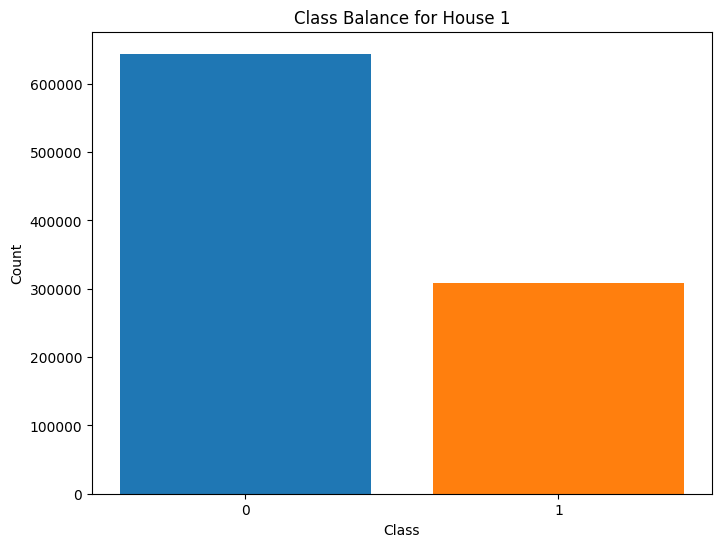

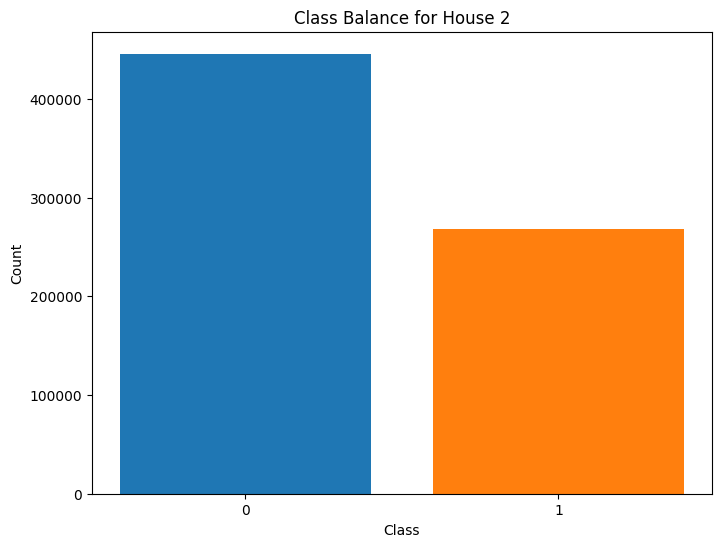

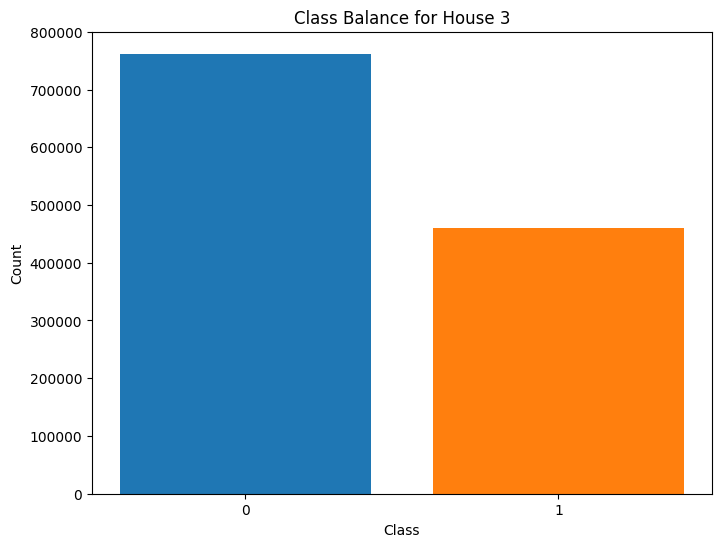

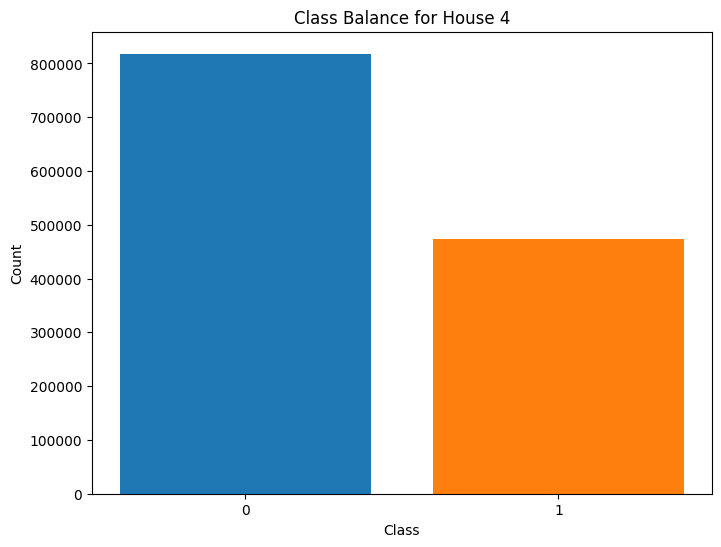

In [10]:
# Class balance
#ys is a list of numpy arrays
for i, y in enumerate(ys):
    unique, counts = np.unique(y, return_counts=True)
    colors = plt.cm.tab10(np.arange(len(counts)))
    
    plt.figure(figsize=(8, 6))
    plt.bar(unique, counts, color=colors)
    plt.title(f'Class Balance for House {i + 1}')
    plt.xlabel('Class')
    plt.ylabel('Count')
    plt.xticks(unique)
    plt.show()


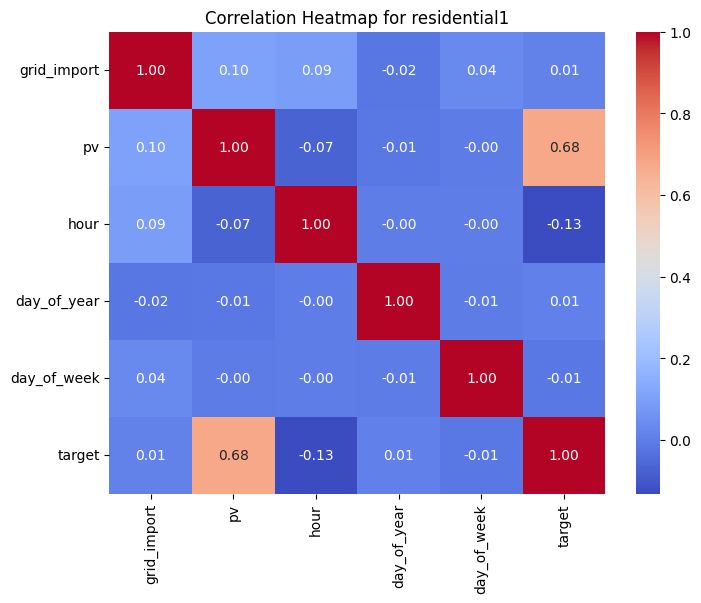

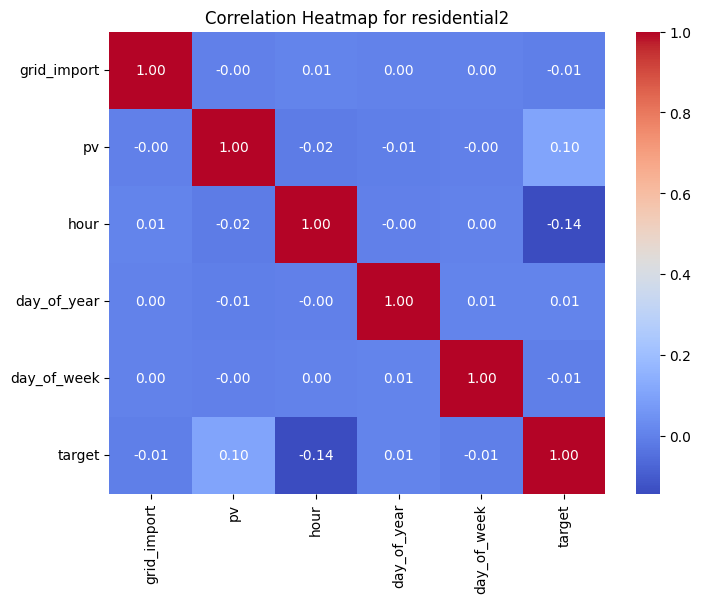

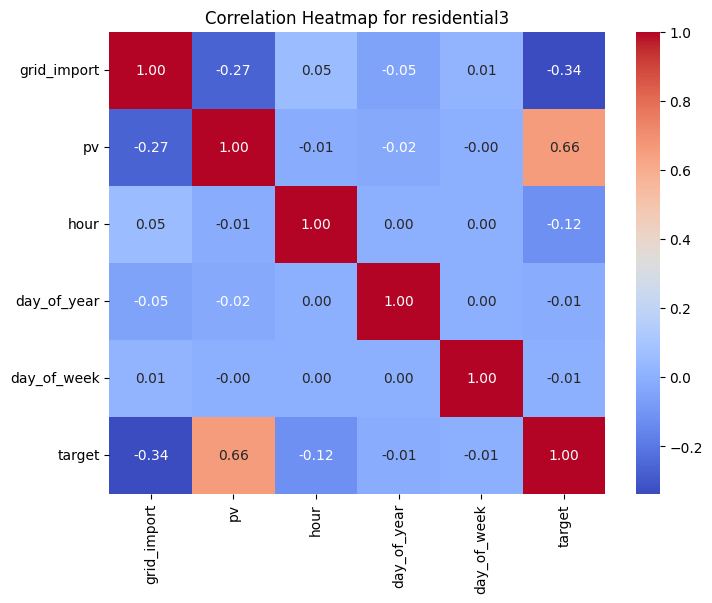

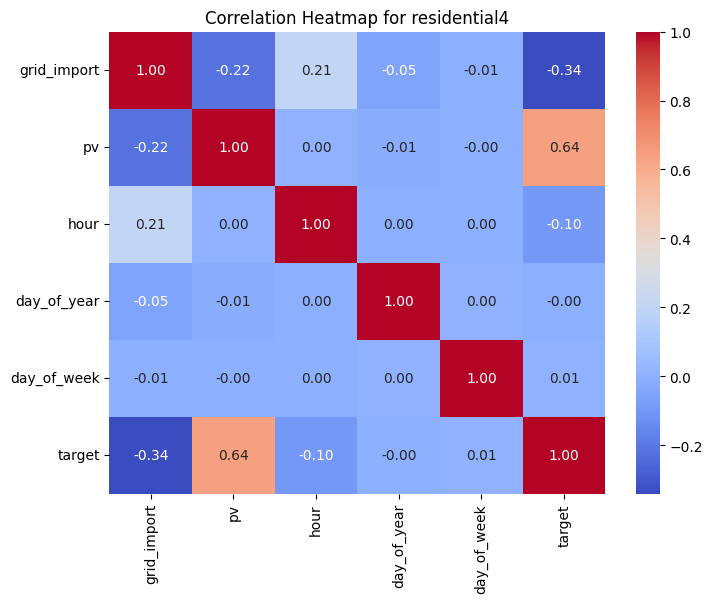

In [11]:
# Añadir el target a cada sub dataframe y calcular las correlaciones
correlations = {}
for key in data_preprocessed.keys():
    correlations[key] = data_preprocessed[key].corr()

# Crear un heatmap para cada sub dataframe
for key in correlations.keys():
    plt.figure(figsize=(8, 6))
    sns.heatmap(correlations[key], annot=True, cmap='coolwarm', fmt='.2f')
    plt.title(f'Correlation Heatmap for {key}')
    plt.show()

In [12]:
# Select a specific week for visualization
start_date = pd.Timestamp('2017-06-01', tz='Europe/Berlin')
end_date = pd.Timestamp('2017-06-08', tz='Europe/Berlin')

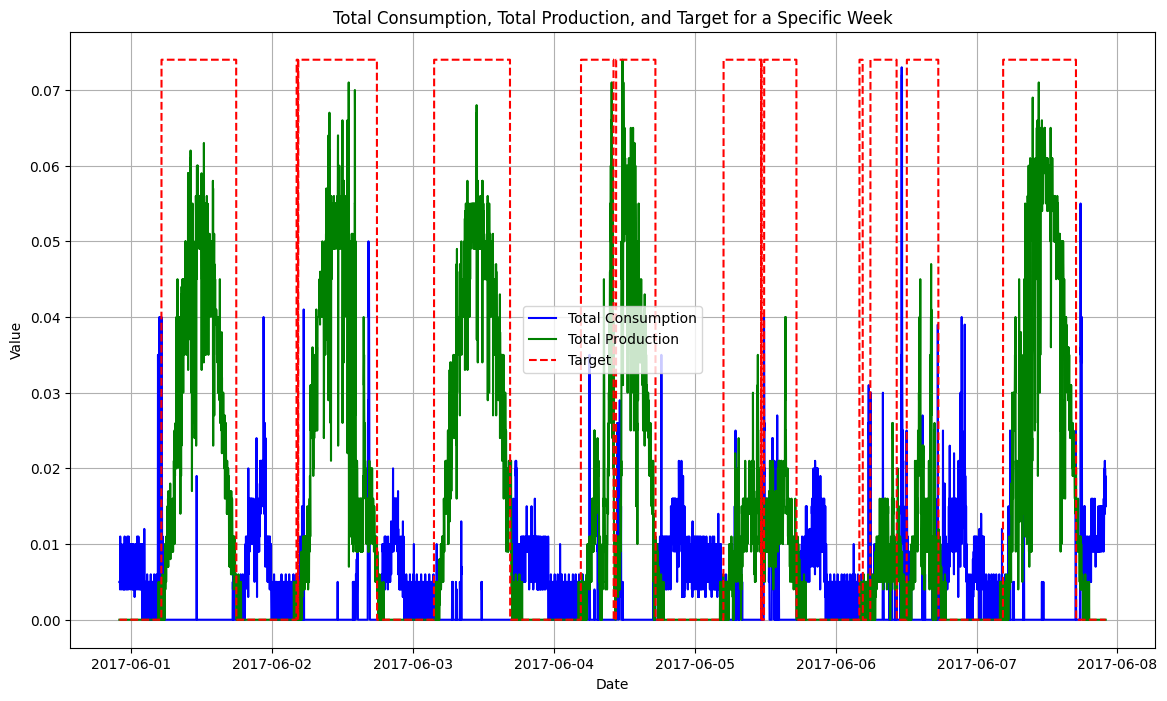

In [13]:

week_data = data_preprocessed['residential2'][start_date:end_date]

plt.figure(figsize=(14, 8))
plt.plot(week_data.index, week_data['grid_import'], label='Total Consumption', color='blue')
plt.plot(week_data.index, week_data['pv'], label='Total Production', color='green')
plt.plot(week_data.index, week_data['target'] * week_data['pv'].max(), label='Target', color='red', linestyle='--')

# Formatting the x-axis to show dates
plt.gca().xaxis.set_major_locator(mdates.DayLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Total Consumption, Total Production, and Target for a Specific Week')
plt.legend()
plt.grid(True)
plt.show()

### Split Data into Training, Validation, and Test Sets
We split the data into training, validation, and test sets to prepare for model training and evaluation.

In [14]:

X_train, X_valid, X_test, y_train, y_valid, y_test = split_data(Xs, ys)

### Remove NaNs
We remove any rows containing NaN values from the datasets before applying PCA.

In [15]:
# Delete rows with NaN values before normalization
X_train = [remove_nans(X, y)[0] for X, y in zip(X_train, y_train)]
y_train = [remove_nans(X, y)[1] for X, y in zip(X_train, y_train)]
X_valid = [remove_nans(X, y)[0] for X, y in zip(X_valid, y_valid)]
y_valid = [remove_nans(X, y)[1] for X, y in zip(X_valid, y_valid)]
X_test = [remove_nans(X, y)[0] for X, y in zip(X_test, y_test)]
y_test = [remove_nans(X, y)[1] for X, y in zip(X_test, y_test)]

2024-08-02 15:54:19 INFO Deleting rows with NaN values
2024-08-02 15:54:19 INFO Deleting rows with NaN values
2024-08-02 15:54:19 INFO Deleting rows with NaN values
2024-08-02 15:54:19 INFO Deleting rows with NaN values
2024-08-02 15:54:19 INFO Deleting rows with NaN values
2024-08-02 15:54:19 INFO Deleting rows with NaN values
2024-08-02 15:54:19 INFO Deleting rows with NaN values
2024-08-02 15:54:19 INFO Deleting rows with NaN values
2024-08-02 15:54:19 INFO Deleting rows with NaN values
2024-08-02 15:54:19 INFO Deleting rows with NaN values
2024-08-02 15:54:19 INFO Deleting rows with NaN values
2024-08-02 15:54:19 INFO Deleting rows with NaN values
2024-08-02 15:54:19 INFO Deleting rows with NaN values
2024-08-02 15:54:19 INFO Deleting rows with NaN values
2024-08-02 15:54:19 INFO Deleting rows with NaN values
2024-08-02 15:54:19 INFO Deleting rows with NaN values
2024-08-02 15:54:19 INFO Deleting rows with NaN values
2024-08-02 15:54:19 INFO Deleting rows with NaN values
2024-08-02

### Data Normalization
We normalize the data to ensure that all features have the same scale.

In [19]:
# Normalize data
X_train_norm, X_valid_norm, X_test_norm = normalize_data(MODELS_DIR, X_train, X_valid, X_test)

2024-08-02 15:56:42 INFO Normalizing data
2024-08-02 15:56:42 INFO Loading scaler from ../models/scaler.pkl


### Apply PCA
We apply PCA to reduce the dimensionality of the data, retaining 95% of the variance.

In [72]:
# Note: We don't need PCA as dimensions are already low

# Apply PCA
#X_train_pca, X_valid_pca, X_test_pca = apply_pca(X_train_norm, X_valid_norm, X_test_norm)

2024-07-29 14:01:33 INFO Applying PCA
2024-07-29 14:01:33 INFO PCA model loaded from models/pca.pkl


### Create TensorFlow Datasets
We create TensorFlow datasets from the processed and normalized data, which will be used for training and evaluating the model.

In [21]:
# Create datasets

train_datasets = [create_tf_dataset(X_train_norm[i], y_train[i], SEQ_LENGTH, BATCH_SIZE, 'train') for i in range(len(X_train_norm))]
valid_datasets = [create_tf_dataset(X_valid_norm[i], y_valid[i], SEQ_LENGTH, BATCH_SIZE, 'valid') for i in range(len(X_valid_norm))]
test_datasets = [create_tf_dataset(X_test_norm[i], y_test[i], SEQ_LENGTH, BATCH_SIZE, 'test') for i in range(len(X_test_norm))]

2024-08-02 15:57:31 INFO Creating dataset train
2024-08-02 15:57:33 INFO Creating dataset train
2024-08-02 15:57:34 INFO Creating dataset train
2024-08-02 15:57:37 INFO Creating dataset train
2024-08-02 15:57:40 INFO Creating dataset valid
2024-08-02 15:57:40 INFO Creating dataset valid
2024-08-02 15:57:40 INFO Creating dataset valid
2024-08-02 15:57:41 INFO Creating dataset valid
2024-08-02 15:57:41 INFO Creating dataset test
2024-08-02 15:57:42 INFO Creating dataset test
2024-08-02 15:57:42 INFO Creating dataset test
2024-08-02 15:57:42 INFO Creating dataset test


In [22]:
combined_train_dataset = train_datasets[0]
for ds in train_datasets[1:]:
    combined_train_dataset = combined_train_dataset.concatenate(ds)

combined_valid_dataset = valid_datasets[0]
for ds in valid_datasets[1:]:
    combined_valid_dataset = combined_valid_dataset.concatenate(ds)

combined_test_dataset = test_datasets[0]
for ds in test_datasets[1:]:
    combined_test_dataset = combined_test_dataset.concatenate(ds)

### Model Training
We build, compile, and train the Transformer model using the training and validation datasets.

In [24]:
model_path = os.path.join(MODELS_DIR, 'transformer_model.keras')
if os.path.exists(model_path):
    logger.info("Loading existing model")
    model = tf.keras.models.load_model(model_path, custom_objects={"Time2Vector": Time2Vector, "TransformerBlock": TransformerBlock})
else:
    input_shape = (SEQ_LENGTH, X_train_norm[0].shape[1])
    logger.info("Building new model")
    model = build_model(SEQ_LENGTH, input_shape, HEAD_SIZE, NUM_HEADS, FF_DIM, NUM_TRANSFORMER_BLOCKS, MLP_UNITS, DROPOUT, MLP_DROPOUT)

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE), loss="binary_crossentropy", metrics=["accuracy"])

model.summary()

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=EARLY_STOPPING_PATIENCE, restore_best_weights=True)

start_time = time.time()

history = model.fit(combined_train_dataset, validation_data=combined_valid_dataset, epochs=EPOCHS, callbacks=[early_stopping], verbose=1)

end_time = time.time()
training_time = end_time - start_time
logger.info(f"Training time: {training_time:.2f} seconds")

model.save(model_path)
logger.info(f"Model saved to {model_path}")

2024-08-02 15:59:13 INFO Building new model


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 60, 5)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time2_vector        │ (None, 60, 2)     │        240 │ input_layer[0][0] │
│ (Time2Vector)       │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 60, 7)     │          0 │ input_layer[0][0… │
│ (Concatenate)       │                   │            │ time2_vector[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 60, 256)   │      2,048 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ transformer_block   │ (None, 60, 256)   │  1,055,236 │ dense[0][0]       │
│ (TransformerBlock)  │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ transformer_block_1 │ (None, 60, 256)   │  1,055,236 │ transformer_bloc… │
│ (TransformerBlock)  │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ transformer_block_2 │ (None, 60, 256)   │  1,055,236 │ transformer_bloc… │
│ (TransformerBlock)  │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ transformer_block_3 │ (None, 60, 256)   │  1,055,236 │ transformer_bloc… │
│ (TransformerBlock)  │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 256)       │          0 │ transformer_bloc… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_9 (Dense)     │ (None, 128)       │     32,896 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_12          │ (None, 128)       │          0 │ dense_9[0][0]     │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_10 (Dense)    │ (None, 1)         │        129 │ dropout_12[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 4,256,257 (16.24 MB)

 Trainable params: 4,256,257 (16.24 MB)

 Non-trainable params: 0 (0.00 B)

 1643/91431 ━━━━━━━━━━━━━━━━━━━━ 3:41:56 148ms/step - accuracy: 0.9203 - loss: 0.2114

### Model Evaluation
We evaluate the model using the test dataset and visualize the training and validation loss.

In [75]:

logger.info("Evaluation on test set")
test_loss, test_accuracy = model.evaluate(test_dataset)
logger.info(f"Loss on test: {test_loss}")
logger.info(f"Accuracy on test: {test_accuracy}")

#plot_loss(history)


2024-07-29 15:37:50 INFO Evaluation on test set


10813/10813 ━━━━━━━━━━━━━━━━━━━━ 182s 17ms/step - accuracy: 0.9998 - loss: 0.0044


2024-07-29 15:40:52 INFO Loss on test: 0.004827520810067654
2024-07-29 15:40:52 INFO Accuracy on test: 0.9998294711112976
